In [ ]:
#Update Gym
!pip install swig
!pip install gym[box2d] --upgrade

In [23]:
import gym
print(gym.__version__)
# NOTE: Version should be 0.26.02

0.26.2


# Define PPO Setup

In [24]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class PolicyNetwork(torch.nn.Module):
    def __init__(self, n=4, in_dim=128):
        super(PolicyNetwork, self).__init__()

        self.fc1 = torch.nn.Linear(in_dim, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, n)
        self.l_relu = torch.nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.l_relu(self.fc1(x))
        x = self.l_relu(self.fc2(x))
        x = self.l_relu(self.fc3(x))
        y = self.fc4(x)
        y = F.softmax(y, dim=-1)
        return y

    def sample_action(self, state):

        if not state is torch.Tensor:
            state = torch.from_numpy(state).float().to(device)

        if len(state.size()) == 1:
            state = state.unsqueeze(0)

        y = self(state)
        dist = Categorical(y)
        action = dist.sample()
        log_probability = dist.log_prob(action)

        return action.item(), log_probability.item()

    def best_action(self, state):

        if not state is torch.Tensor:
            state = torch.from_numpy(state).float().to(device)

        if len(state.size()) == 1:
            state = state.unsqueeze(0)

        y = self(state).squeeze()
        action = torch.argmax(y)

        return action.item()

    def evaluate_actions(self, states, actions):
        y = self(states)
        dist = Categorical(y)
        entropy = dist.entropy()
        log_probabilities = dist.log_prob(actions)

        return log_probabilities, entropy


class ValueNetwork(torch.nn.Module):
    def __init__(self, in_dim=128):
        super(ValueNetwork, self).__init__()

        self.fc1 = torch.nn.Linear(in_dim, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 1)
        self.l_relu = torch.nn.LeakyReLU(0.1)

    def forward(self, x):

        x = self.l_relu(self.fc1(x))
        x = self.l_relu(self.fc2(x))
        x = self.l_relu(self.fc3(x))
        y = self.fc4(x)

        return y.squeeze(1)

    def state_value(self, state):

        if not state is torch.Tensor:
            state = torch.from_numpy(state).float().to(device)

        if len(state.size()) == 1:
            state = state.unsqueeze(0)

        y = self(state)

        return y.item()


def ac_loss_clipped(new_log_probabilities, old_log_probabilities, advantages, epsilon_clip=0.2):
    probability_ratios = torch.exp(new_log_probabilities - old_log_probabilities)
    clipped_probabiliy_ratios = torch.clamp(
        probability_ratios, 1 - epsilon_clip, 1 + epsilon_clip
    )

    surrogate_1 = probability_ratios * advantages
    surrogate_2 = clipped_probabiliy_ratios * advantages

    return -torch.min(surrogate_1, surrogate_2)

def train_combined_networks(policy_model, value_model, combined_optimizer, data_loader, epochs=40, clip=0.2):
    c1 = 0.01  # Coefficient for entropy regularization
    c2 = 0.5   # Coefficient for value loss weight

    for epoch in range(epochs):
        policy_losses = []
        value_losses = []

        for observations, actions, advantages, log_probabilities, rewards_to_go in data_loader:
            observations = observations.float().to(device)
            actions = actions.long().to(device)
            advantages = advantages.float().to(device)
            old_log_probabilities = log_probabilities.float().to(device)
            rewards_to_go = rewards_to_go.float().to(device)

            combined_optimizer.zero_grad()

            new_log_probabilities, entropy = policy_model.evaluate_actions(observations, actions)
            policy_loss = (
                ac_loss_clipped(
                    new_log_probabilities,
                    old_log_probabilities,
                    advantages,
                    epsilon_clip=clip,
                ).mean()
                - c1 * entropy.mean()
            )
            policy_losses.append(policy_loss.item())

            values = value_model(observations)
            value_loss = c2 * F.mse_loss(values, rewards_to_go)
            value_losses.append(value_loss.item())

            total_loss = policy_loss + value_loss

            total_loss.backward()
            combined_optimizer.step()


In [25]:
import numpy as np
from torch.utils.data import Dataset


def cumulative_sum(array, gamma=1.0):
    curr = 0
    cumulative_array = []

    for a in array[::-1]:
        curr = a + gamma * curr
        cumulative_array.append(curr)

    return cumulative_array[::-1]


class Episode:
    def __init__(self, gamma=0.99, lambd=0.95):
        self.observations = []
        self.actions = []
        self.advantages = []
        self.rewards = []
        self.rewards_to_go = []
        self.values = []
        self.log_probabilities = []
        self.gamma = gamma
        self.lambd = lambd

    def append(
        self, observation, action, reward, value, log_probability, reward_scale=20
    ):
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward / reward_scale)
        self.values.append(value)
        self.log_probabilities.append(log_probability)

    def end_episode(self, last_value):
        rewards = np.array(self.rewards + [last_value])
        values = np.array(self.values + [last_value])
        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]
        self.advantages = cumulative_sum(deltas.tolist(), gamma=self.gamma * self.lambd)
        self.rewards_to_go = cumulative_sum(rewards.tolist(), gamma=self.gamma)[:-1]


def normalize_list(array):
    array = np.array(array)
    array = (array - np.mean(array)) / (np.std(array) + 1e-5)
    return array.tolist()


class History(Dataset):
    def __init__(self):
        self.episodes = []
        self.observations = []
        self.actions = []
        self.advantages = []
        self.rewards = []
        self.rewards_to_go = []
        self.log_probabilities = []

    def free_memory(self):
        del self.episodes[:]
        del self.observations[:]
        del self.actions[:]
        del self.advantages[:]
        del self.rewards[:]
        del self.rewards_to_go[:]
        del self.log_probabilities[:]

    def add_episode(self, episode):
        self.episodes.append(episode)

    def build_dataset(self):
        for episode in self.episodes:
            self.observations += episode.observations
            self.actions += episode.actions
            self.advantages += episode.advantages
            self.rewards += episode.rewards
            self.rewards_to_go += episode.rewards_to_go
            self.log_probabilities += episode.log_probabilities

        assert (
            len(
                {
                    len(self.observations),
                    len(self.actions),
                    len(self.advantages),
                    len(self.rewards),
                    len(self.rewards_to_go),
                    len(self.log_probabilities),
                }
            )
            == 1
        )

        self.advantages = normalize_list(self.advantages)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return (
            self.observations[idx],
            self.actions[idx],
            self.advantages[idx],
            self.log_probabilities[idx],
            self.rewards_to_go[idx],
        )


# TRAC Optimizer

## Define Erfi function in Pytorch

In [26]:
import torch
# We depend on Erfi function, but python.special currently has no implementation.
# We instead modify and rely on https://github.com/redsnic/torch_erf

def polyval(x,coeffs):
    """Implementation of the Horner scheme to evaluate a polynomial

    taken from https://discuss.pytorch.org/t/polynomial-evaluation-by-horner-rule/67124

    Args:
        x (torch.Tensor): variable
        coeffs (torch.Tensor): coefficients of the polynomial
    """
    curVal=0
    for curValIndex in range(len(coeffs)-1):
        curVal=(curVal+coeffs[curValIndex])*x[0]
    return(curVal+coeffs[len(coeffs)-1])


class ERF_1994(torch.nn.Module):
    """Class to compute the error function of a complex number (extends torch.special.erf behavior)

    This class is based on the algorithm proposed in:
    Weideman, J. Andre C. "Computation of the complex error function." SIAM Journal on Numerical Analysis 31.5 (1994): 1497-1518
    """
    def __init__(self, n_coefs):
        """Defaul constructor

        Args:
            n_coefs (integer): The number of polynomial coefficients to use in the approximation
        """
        super(ERF_1994, self).__init__()
        # compute polynomial coefficients and other constants
        self.N = n_coefs
        self.i = torch.complex(torch.tensor(0.),torch.tensor(1.))
        self.M = 2*self.N
        self.M2 = 2*self.M
        self.k = torch.linspace(-self.M+1, self.M-1, self.M2-1)
        self.L = torch.sqrt(self.N/torch.sqrt(torch.tensor(2.)))
        self.theta = self.k*torch.pi/self.M
        self.t = self.L*torch.tan(self.theta/2)
        self.f = torch.exp(-self.t**2)*(self.L**2 + self.t**2)
        self.a = torch.fft.fft(torch.fft.fftshift(self.f)).real/self.M2
        self.a = torch.flipud(self.a[1:self.N+1])

    def w_algorithm(self, z):
        """Compute the Faddeeva function of a complex number

        The constant coefficients are computed in the constructor of the class.

        Weideman, J. Andre C. "Computation of the complex error function." SIAM Journal on Numerical Analysis 31.5 (1994): 1497-1518

        Args:
            z (torch.Tensor): A tensor of complex numbers (any shape is allowed)

        Returns:
            torch.Tensor: w(z) for each element of z
        """
        Z = (self.L+self.i*z)/(self.L-self.i*z)
        p = polyval(Z.unsqueeze(0), self.a)
        w = 2*p/(self.L-self.i*z)**2+(1/torch.sqrt(torch.tensor(torch.pi)))/(self.L-self.i*z)
        return w

    def forward(self, z):
        """Compute the error function of a complex number

        The result is computed by manipulating the Faddeeva function.

        Args:
            z (torch.Tensor): A tensor of complex numbers (any shape is allowed)

        Returns:
            torch.Tensor: erf(z) for each element of z
        """
        # exploit the symmetry of the error function
        # find the sign of the real part
        sign_r = torch.sign(z.real)
        sign_i = torch.sign(z.imag)
        # flip sign of imaginary part if negative
        z = torch.complex(torch.abs(z.real), torch.abs(z.imag))
        out = -torch.exp(torch.log(self.w_algorithm(z*self.i)) - z**2) + 1
        return torch.complex(out.real*sign_r, out.imag*sign_i)

    def backward(self, z):
        """Compute the gradient of the error function of a complex number.

        As we know the analytical derivative of the the error function, we can use it directly.

        Args:
            z (torch.Tensor): A tensor of complex numbers (any shape is allowed)
        Returns:
            torch.Tensor: grad(erf(z)) for each element of x
        """
        return 2/torch.sqrt(torch.tensor(torch.pi))*torch.exp(-z**2)

erf_torch = ERF_1994(128)

def erfi(x):
    if not torch.is_floating_point(x):
        x = x.to(torch.float32)

    # Convert x to a complex tensor where the real part is zero
    ix = torch.complex(torch.zeros_like(x), x)

    # Compute erf(ix) / i
    erfi_x = erf_torch(ix).imag  # Extract the imaginary part of erf(ix)
    return erfi_x


## TRAC Wrapper

In [27]:
from typing import Tuple, Any, Callable, Dict
import torch

# We closely follow the meta-optimizer structure from the code in
# Cutkosky et. al 2023
def _init_state(
        optimizer: torch.optim.Optimizer,
        theta_ref: Dict[torch.Tensor, torch.Tensor],
        betas: Tuple[float],
        s_prev: float,
        eps: float):
    if '_trac' not in optimizer.state:
        optimizer.state['_trac'] = {
            'betas': torch.tensor(betas),
            's_prev': torch.tensor(s_prev),
            'eps': eps,
            's': torch.zeros(len(betas)),
            'theta_ref': {},
            'variance': torch.zeros(len(betas)),
            'sigma': torch.full((len(betas),), 1e-8),
            'iter_count': 0,
        }
        _init_reference(optimizer, theta_ref)

def _init_reference(
        optimizer: torch.optim.Optimizer,
        theta_ref: Dict[torch.Tensor, torch.Tensor],):
    '''
    Args:
        optimizer: optimizer instance to store reference for.
        theta_ref: mapping of parameters to their initial values at the start of optimization.
    '''
    for group in optimizer.param_groups:
        for p in group['params']:
            optimizer.state['_trac'][p] = {
                'ref': theta_ref[p].clone(),
            }
            

def _step(
        optimizer: torch.optim.Optimizer,
        base_step: Callable,
        betas: Tuple[float],
        s_prev: float,
        eps: float,
        ):
    '''
    Args:
        optimizer: trac optimizer instance
        base_step: The "step" function of the base optimizer
        betas: list of beta values.
        s_init: initial scale value.
        eps: epsilon value.
    '''

    prev_grad = torch.is_grad_enabled()


    torch.set_grad_enabled(False)
    updates = {}
    grads = {}
    deltas = {}

    for group in optimizer.param_groups:
        for p in group['params']:

            if p.grad is None:
                grads[p] = None
            else:
                grads[p] = p.grad.clone()
            updates[p] = p.data.clone()

    torch.set_grad_enabled(prev_grad)
    result = base_step(None)
    torch.set_grad_enabled(False)
    
    _init_state(optimizer, updates, betas, s_prev, eps)
    trac_state = optimizer.state['_trac']


    for group in optimizer.param_groups:
        for p in group['params']:
            if grads[p] is None:
                continue

            theta_ref = trac_state[p]['ref']

            deltas[p] = (updates[p] - theta_ref)/(torch.sum(trac_state['s']) + trac_state['eps'])

            updates[p].copy_(p-updates[p])

    h = 0.0
    for group in optimizer.param_groups:
        for p in group['params']:

            if grads[p] is None:
                continue

            grad = grads[p]

            delta = deltas[p]
            product = torch.dot(delta.flatten(), grad.flatten())
            if product.isnan():
                raise ValueError("NaNs in product")
            h += product

            delta.add_(updates[p])

    device = h.device

    for key in trac_state:
        try:
            if trac_state[key].device != device:
                trac_state[key] = trac_state[key].to(device)
        except:
            pass

    s = trac_state['s']
    s_prev = trac_state['s_prev']
    betas = trac_state['betas']
    eps = trac_state['eps']
    variance = trac_state['variance'] 
    sigma = trac_state['sigma']                                 
    trac_state['iter_count'] += 1

    variance.mul_(
        betas**2).add_(torch.square(h))
    sigma.mul_(betas).sub_(h)
    f_term = s_prev / (erfi(torch.tensor(1.0) / torch.sqrt(torch.tensor(2.0))))
    s_term = erfi(sigma / (torch.sqrt(torch.tensor(2.0)) * torch.sqrt(variance) + eps))
    if (f_term * s_term).isnan().any():
        raise ValueError("NaNs in s")
    s.copy_(f_term * s_term)

    for group in optimizer.param_groups:
        for p in group['params']:

            if grads[p] is None:
                continue

            theta_ref = trac_state[p]['ref']
            delta = deltas[p]
            s_sum = torch.sum(s)

            scale = max(s_sum, 0.0)
            p.copy_(theta_ref + delta * scale)

    log_data = {
        'iter_count': trac_state['iter_count'],
        's': torch.sum(s).item(),
    }

    torch.set_grad_enabled(prev_grad)
    return result, log_data


class trac:
    pass

def is_trac(opt):
    return isinstance(opt, trac)

def start_trac(
        log_file,
        Base: Any,
        betas: Tuple[float] = (0.9, 0.99, 0.999, 0.9999,
                               0.99999, 0.999999),
        s_prev: float = 1e-8,
        eps: float = 1e-8,
        ):

    class TRACOPT(Base, trac):
        '''
        Wraps the base opt with trac.
        
        '''

        def step(self):
            result, log_data = _step(self, super().step, betas, s_prev, eps)
            with open (log_file, 'a') as f:
                f.write(str(log_data) + '\n')
            return result

    TRACOPT.__name__ += Base.__name__

    return TRACOPT


# Lifelong Control Setting

In [9]:
import gym
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import random


2024-06-11 11:38:13.373587: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 11:38:13.420720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 11:38:25.120438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [32]:
# SET THE SEED
seed = 2024
random.seed(seed)
np.random.seed(seed)

# num distribution shifts
levels = 10

# Hyperparameters
lr = 0.01
max_episodes = 2
train_epochs = 5
max_timesteps = 400
state_scale = 1.0
reward_scale = 20.0
batch_size = 32

# when to introduce distribution shift
level_switch = 200
max_iterations = levels * level_switch

# peturbation range
rp_range = 2

In [33]:
def get_peturbations(env_name, seed):
  env = gym.make(env_name, render_mode="rgb_array")
  observation = env.reset()[0]
  random_perturbations = [
        np.random.normal(0, rp_range, observation.shape) for _ in range(levels)
    ]
  # make the first random perturbation zero
  random_perturbations[0] = np.zeros(observation.shape)
  return random_perturbations
def train(env_name, opt_choice, random_perturbations):

    # Create log txt files
    trac_reward_log_file = f'logs/trac_reward_log_{env_name}_{seed}.txt'
    base_reward_log_file = f'logs/base_reward_log_{env_name}_{seed}.txt'

    # Setup env
    env = gym.make(env_name, render_mode="rgb_array")
    observation = env.reset()[0]
    n_actions = env.action_space.n
    feature_dim = observation.size

    tqdm_bar = tqdm(range(max_iterations), desc="Training", unit="iteration")

    value_model = ValueNetwork(in_dim=feature_dim).to(device)
    policy_model = PolicyNetwork(in_dim=feature_dim, n=n_actions).to(device)

    trac_combined_optimizer = start_trac(log_file=f'logs/trac_{env_name}.text', Base=optim.Adam)(
        [
            {"params": policy_model.parameters(), "lr": lr},
            {"params": value_model.parameters(), "lr": lr},
        ]
    )

    base_combined_optimizer = torch.optim.Adam(
        [
            {"params": policy_model.parameters(), "lr": lr},
            {"params": value_model.parameters(), "lr": lr},
        ]
    )
    if opt_choice == "TRAC":
        combined_optimizer = trac_combined_optimizer
        reward_log_file = trac_reward_log_file
        print("USING TRAC.")
    if opt_choice == "base":
        combined_optimizer = base_combined_optimizer
        reward_log_file = base_reward_log_file
    history = History()
    level = 0
    for ite in tqdm_bar:
        # Switch perturbation level
        if ite % level_switch == 0:
            random_perturbation = random_perturbations[level]
            level += 1

        episodes_reward = []

        for _ in range(max_episodes):
            observation = env.reset()[0]
            observation += random_perturbation
            episode = Episode()

            for timestep in range(max_timesteps):
                action, log_probability = policy_model.sample_action(observation / state_scale)
                value = value_model.state_value(observation / state_scale)

                new_observation, reward, done, _, _ = env.step(action)
                new_observation += random_perturbation

                episode.append(
                    observation=observation / state_scale,
                    action=action,
                    reward=reward,
                    value=value,
                    log_probability=log_probability,
                    reward_scale=reward_scale,
                )

                observation = new_observation

                if done:
                    episode.end_episode(last_value=0)
                    break

                if timestep == max_timesteps - 1:
                    value = value_model.state_value(observation / state_scale)
                    episode.end_episode(last_value=value)

            episodes_reward.append(reward_scale * np.sum(episode.rewards))
            history.add_episode(episode)

        mean_rewards = np.mean(episodes_reward)
        tqdm_bar.set_postfix(mean_rewards=mean_rewards)

        with open(reward_log_file, 'a') as f:
            f.write(str(mean_rewards) + '\n')
        history.build_dataset()
        data_loader = DataLoader(history, batch_size=batch_size, shuffle=True)
        train_combined_networks(policy_model, value_model, combined_optimizer, data_loader, train_epochs)
        history.free_memory()


### Plotting

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def read_data(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()
    return data

def plot(env_name, seed):
    # Read data from files
    trac_data = read_data(f'logs/trac_reward_log_{env_name}_{seed}.txt')
    base_data = read_data(f'logs/base_reward_log_{env_name}_{seed}.txt')

    # Convert data to float
    trac_data = [float(i) for i in trac_data]
    base_data = [float(i) for i in base_data]


    # Smooth trac and base data
    window = 5
    trac_data = np.convolve(trac_data, np.ones(window) / window, mode='valid')
    base_data = np.convolve(base_data, np.ones(window) / window, mode='valid')

    # Create a plot with seaborn
    sns.set(style="darkgrid")
    plt.figure(figsize=(10, 6))

    plt.plot(base_data, label='Adam PPO', color='#4a69bd')
    plt.plot(trac_data, label='TRAC PPO', color='#b71540')

    plt.xlabel('Timesteps')
    plt.ylabel('Mean Episode Reward')
    plt.title(f'{env_name}', fontsize=24)
    plt.legend()
    plt.show()


# Compare one seed results for Acrobot

## Train with Adam

In [35]:
peturbations = get_peturbations("Acrobot-v1", seed)
print("Online Peturbations are")
print(peturbations)
env = "Acrobot-v1"
opt = "base"
train(env, opt, peturbations)

Online Peturbations are
[array([0., 0., 0., 0., 0., 0.]), array([-5.239924  , -2.65058914,  0.91997724,  0.20410329,  2.10710556,
        3.24808522]), array([-3.00127004, -0.55566338,  2.38799004,  1.72363065, -0.83409209,
       -0.49907283]), array([ 1.88735471, -1.53262128,  0.41645746,  2.81744585, -2.97820802,
       -2.95161707]), array([ 1.98169263, -1.76646085, -0.73236775, -3.06941007, -0.70315102,
        1.27983623]), array([ 1.37847833,  1.51450473, -2.86109954, -0.8577586 , -1.37002372,
       -0.25128173]), array([ 2.28917448,  0.65441957, -0.27345488,  0.35838783,  1.93795414,
        0.01174018]), array([ 1.18101088, -0.78495275,  0.07182293, -0.66150991,  1.61755215,
        0.10662189]), array([-2.63780402, -2.15956139, -0.75193655,  0.29745353,  3.62983768,
        1.10499787]), array([-1.07844989,  1.85410224,  2.39777336,  0.03593557,  2.03176482,
       -2.36861302])]


Training:  14%|█▍        | 278/2000 [05:39<35:01,  1.22s/iteration, mean_rewards=-400]


KeyboardInterrupt: 

## Train with TRAC

In [ ]:
print("Online Peturbations are")
print(peturbations)
opt = "TRAC"
train(env, opt, peturbations)

Online Peturbations are
[array([0., 0., 0., 0., 0., 0.]), array([ 2.17157788,  0.34053703,  2.23921071, -1.31344863, -5.58455019,
       -1.31314464]), array([ 0.64917973, -3.78084544, -0.22526347,  1.38430828, -2.41044139,
        0.2959818 ]), array([ 1.38837342, -0.41074039,  4.29486731, -1.89647011,  0.57554351,
       -0.2898865 ]), array([ 0.69971711, -0.74984953,  1.69061481,  1.49414689, -2.87732306,
       -1.74682857]), array([-2.14713326,  0.4396411 ,  0.69225986,  2.16534063,  2.05933155,
        1.17132279]), array([ 0.59946581,  0.86106039,  2.59435245, -2.60952034, -1.13732226,
       -2.84250946]), array([ 6.13985793,  0.84625234, -1.09965102, -3.67620658, -2.38453755,
       -0.92809013]), array([ 2.8292598 ,  3.0283006 ,  2.54238781, -0.29499719, -1.99801052,
        3.57734236]), array([ 1.31372917, -0.01099749, -0.65765122,  1.81880701, -1.59662735,
       -1.40798752])]


Training:   0%|          | 0/2000 [00:00<?, ?iteration/s]

USING PACE.


Training: 100%|██████████| 2000/2000 [1:01:54<00:00,  1.86s/iteration, mean_rewards=-400]


## Plot Results

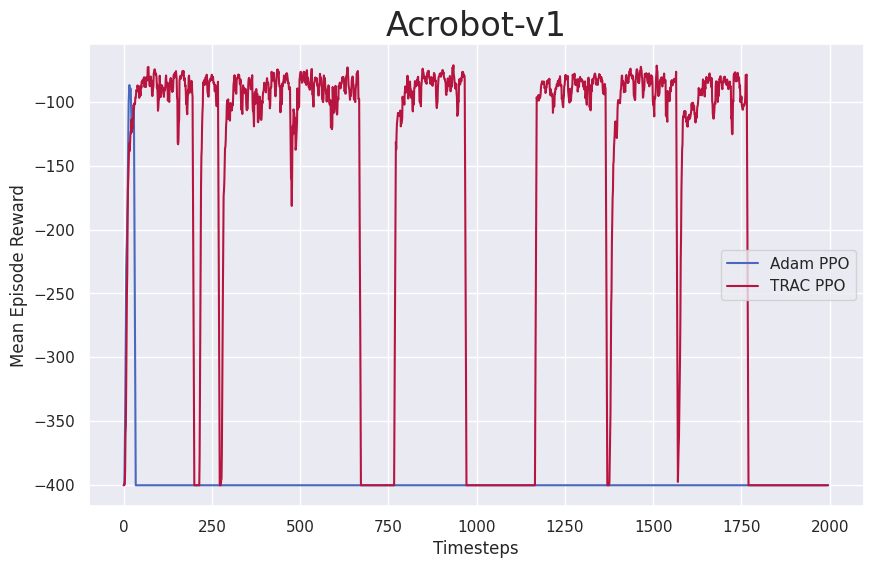

In [ ]:
plot(env,seed)

# Compare one seed results for CartPole

## Train with Adam

In [36]:
peturbations = get_peturbations("CartPole-v1", seed)
print("Online Peturbations are")
print(peturbations)
env = "CartPole-v1"
opt = "base"
train(env, opt, peturbations)

Online Peturbations are
[array([0., 0., 0., 0.]), array([ 0.92782529,  1.36819143, -4.77377769, -0.01497228]), array([-1.09384215,  0.94978324, -3.06290554,  3.84519343]), array([-0.29138351, -0.60629324, -1.81915061,  2.01540922]), array([ 3.19307222, -2.58054596, -1.01671636,  1.86447184]), array([ 0.99047822, -1.5946504 ,  0.49790264,  1.99205513]), array([-1.79682735,  1.07068881,  2.16418162,  0.18512872]), array([-1.27086281,  1.18398122, -0.9168031 ,  4.79663024]), array([-2.0079268 ,  0.65043091,  2.79887304, -0.89485782]), array([-2.45459832, -2.20658831, -1.69573544, -1.09117524])]


Training: 100%|██████████| 2000/2000 [02:08<00:00, 15.58iteration/s, mean_rewards=9.5] 


## Train with TRAC

In [37]:
print("Online Peturbations are")
print(peturbations)
opt = "TRAC"
train(env, opt, peturbations)

Online Peturbations are
[array([0., 0., 0., 0.]), array([ 0.92782529,  1.36819143, -4.77377769, -0.01497228]), array([-1.09384215,  0.94978324, -3.06290554,  3.84519343]), array([-0.29138351, -0.60629324, -1.81915061,  2.01540922]), array([ 3.19307222, -2.58054596, -1.01671636,  1.86447184]), array([ 0.99047822, -1.5946504 ,  0.49790264,  1.99205513]), array([-1.79682735,  1.07068881,  2.16418162,  0.18512872]), array([-1.27086281,  1.18398122, -0.9168031 ,  4.79663024]), array([-2.0079268 ,  0.65043091,  2.79887304, -0.89485782]), array([-2.45459832, -2.20658831, -1.69573544, -1.09117524])]


Training:   0%|          | 0/2000 [00:00<?, ?iteration/s, mean_rewards=26]

USING TRAC.


Training:   9%|▉         | 185/2000 [06:21<1:02:18,  2.06s/iteration, mean_rewards=400]


KeyboardInterrupt: 

## Plot

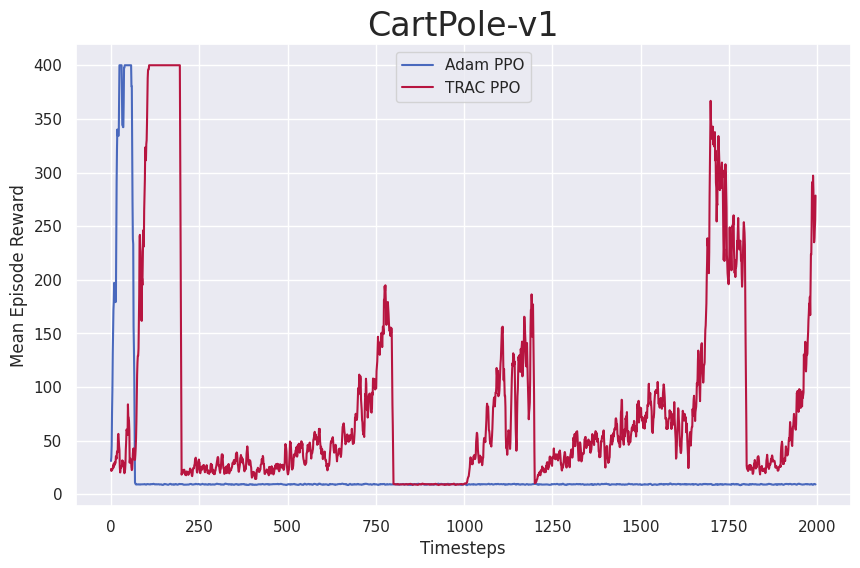

In [ ]:
plot(env,seed)

# Compare one seed results for LunarLander

## Train with Adam

In [ ]:
env = "LunarLander-v2"
peturbations = get_peturbations(env, seed)
print("Online Peturbations are")
print(peturbations)
opt = "base"
train(env, opt, peturbations)

Online Peturbations are
[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([-2.0079268 ,  0.65043091,  2.79887304, -0.89485782, -2.45459832,
       -2.20658831, -1.69573544, -1.09117524]), array([ 0.17443612,  0.20773286,  1.37988336,  0.94118602, -3.22100874,
        2.25633408, -1.40989297, -3.26433332]), array([ 0.80256681, -0.28995543, -1.23964918, -1.00915434,  1.83726094,
       -0.04131756, -0.34566563,  0.43507223]), array([-2.61347919,  0.16253191, -0.49465057,  1.62261508,  0.21936038,
        3.78905087,  1.18040223,  0.366775  ]), array([-1.25746734, -2.2225763 , -1.90403545,  3.55554009,  1.10756424,
       -0.72152412,  2.56358724, -4.10257526]), array([-1.76960483, -0.40704985, -5.2108199 ,  3.25156089,  2.9457686 ,
       -1.01028411,  0.08907027, -0.38054472]), array([ 2.60647874,  1.77401358,  0.10560635,  4.91972652, -1.88837331,
       -0.7740599 ,  1.03906547,  0.74652167]), array([ 1.38343614, -0.10384657,  2.18803684,  1.92105522,  1.92164754,
        0.52874226,  2


Training:   0%|          | 0/2000 [00:00<?, ?iteration/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):

Training: 100%|██████████| 2000/2000 [16:46<00:00,  1.99iteration/s, mean_rewards=-120]


## Train with TRAC

In [ ]:
opt = "TRAC"
train(env, opt, peturbations)


Training:   0%|          | 0/2000 [00:00<?, ?iteration/s]

USING PACE.



Training: 100%|██████████| 2000/2000 [38:28<00:00,  1.15s/iteration, mean_rewards=-213]


## Plot

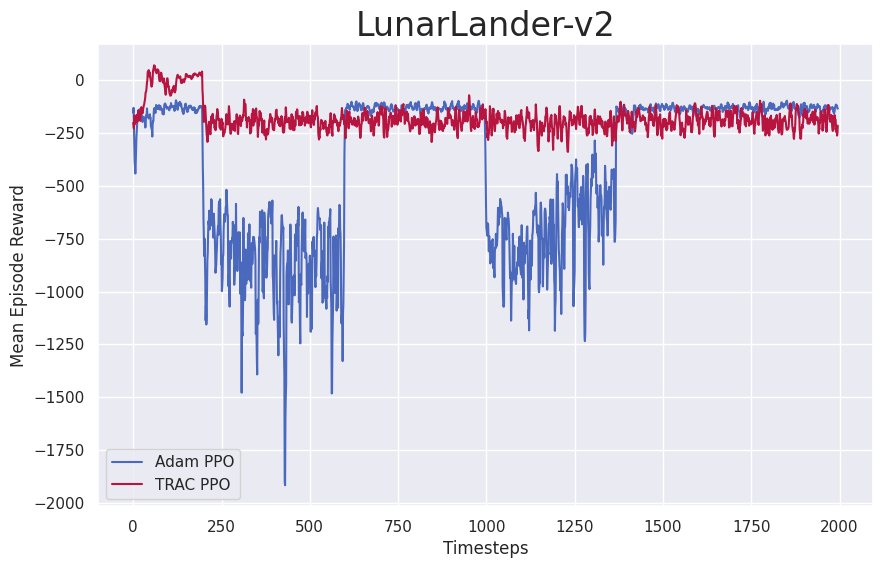

In [21]:
plot(env,seed)